In [1]:
%%capture
!pip install tensorflow-datasets==4.8 --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install pydot --quiet
!pip install transformers==4.17 --quiet
!pip install -U scikit-learn

In [2]:
#Tensorflow libiries
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

#Transformers - BERT from huggingface
from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()
from transformers import AutoConfig
from tensorflow.keras.callbacks import EarlyStopping

#NLP libiries
import sklearn as sk
from sklearn.metrics import classification_report
import os
import nltk
from nltk.data import find

#data process
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
import pandas as pd
import math
from bs4 import BeautifulSoup
import os
import json


In [3]:
#loading the pre-trained tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

In [17]:
#load the dataset with error handling
try:
    train_df = pd.read_csv('full_train_data(Revised).csv')
except pd.errors.ParserError as e:
    print(f"Error reading CSV: {e}")
    # Print the lines around the problematic row
    with open('full_train_data(Revised).csv', 'r') as f:
        lines = f.readlines()
        for i in range(17622, 17626):
            if i < len(lines):
                print(lines[i])

test_df = pd.read_csv('full_dataset(Revised).csv')

# Adjust pandas display settings to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full content of each column
pd.set_option('display.width', None)  # Auto-detect width of the display




In [18]:
train_df.columns

Index(['title', 'date', 'content_original', 'bias', 'bias_text', 'source'], dtype='object')

In [19]:
#targeted news ogranization to be removed

target_news_org = ['Washington Times', 'CNN (Web News)', 'NPR Online News', 'Politico', 'Vox' ]

In [20]:
train_df = train_df[~train_df['source'].isin(target_news_org)]


In [21]:
test_df = test_df[test_df['source'].isin(target_news_org)]

In [8]:
test_df['source'].unique()

array(['Washington Times', 'CNN (Web News)', 'Politico',
       'NPR Online News', 'Vox'], dtype=object)

In [22]:
# Shuffle the entire dataset
test_df_shuffled = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate the size of each batch
batch_size = 2000

# Create three batches
test_df_1 = test_df_shuffled.iloc[:batch_size]
test_df_2 = test_df_shuffled.iloc[batch_size:2*batch_size]
test_df_3 = test_df_shuffled.iloc[2*batch_size:3*batch_size]

# If you want to ensure each batch has exactly 2000 samples,
# you can use the following instead:
test_df_1 = test_df_shuffled.sample(n=batch_size, random_state=42)
test_df_2 = test_df_shuffled.drop(test_df_1.index).sample(n=batch_size, random_state=43)
test_df_3 = test_df_shuffled.drop(test_df_1.index).drop(test_df_2.index).sample(n=batch_size, random_state=44)

In [10]:
train_df['source'].unique()

array(['Christian Science Monitor', 'The Guardian', 'Reason', 'Townhall',
       'Fox Online News', 'Yahoo! The 360', 'TheBlaze.com',
       'National Review', 'Wall Street Journal - Editorial',
       'Business Insider', 'Daily Kos', 'Bloomberg', 'The Week - News',
       'Daily Beast', 'USA TODAY', 'Breitbart News', 'Fox News',
       'Chicago Sun-Times', 'Charles Krauthammer', 'The Atlantic',
       'HotAir', 'MarketWatch', 'New York Times - News', 'Salon',
       'Guest Writer - Left', 'Newsmax', 'FiveThirtyEight',
       'Michelle Malkin', 'Polish Times', 'Reuters', 'Associated Press',
       'Victor Hanson', 'Pew Research Center',
       'New York Times (Online News)', 'City Journal', 'Jonah Goldberg',
       'Guest Writer - Right', 'Fox News Opinion', 'Yahoo! News', 'Slate',
       'Washington Post', 'Mother Jones', 'Newsmax (News)', 'Defense One',
       'Independent Journal Review', 'Peacock Panache',
       'Detroit Free Press', 'CNBC', 'Newsmax - News',
       'Washington Fr

In [ ]:
print(f"basic train_df info: ",train_df.shape)

basic train_df info:  (20114, 6)


In [23]:
print(f"basic train_df info after deleting the top-5 outlier news org: ",train_df.shape)


basic train_df info after deleting the top-5 outlier news org:  (11332, 6)


In [ ]:
print(f"basic test_df info: ",test_df.shape)

basic test_df info:  (5029, 6)


In [24]:
print(f"batch 1 train_df1 info after deleting the top-5 outlier news org: ",test_df_1.shape)
print(f"batch 2 train_df2 info after deleting the top-5 outlier news org: ",test_df_1.shape)
print(f"batch 3 train_df3 info after deleting the top-5 outlier news org: ",test_df_1.shape)

batch 1 train_df1 info after deleting the top-5 outlier news org:  (2000, 6)
batch 2 train_df2 info after deleting the top-5 outlier news org:  (2000, 6)
batch 3 train_df3 info after deleting the top-5 outlier news org:  (2000, 6)


In [26]:
# extract the train and test text from both dataframes
train_text = train_df['content_original'][:8000]
train_text_labels = train_df['bias'][:8000]

# For validation, use the remaining data after the first 8000 rows
validate_text = train_df['content_original'][8000:]
validate_text_labels = train_df['bias'][8000:]

test1_text = test_df_1['content_original']
test1_text_labels = test_df_1['bias']

test2_text = test_df_2['content_original']
test2_text_labels = test_df_2['bias']

test3_text = test_df_3['content_original']
test3_text_labels = test_df_3['bias']


print(f"size of training dataset: ",len(train_text))
print()
print(f"size of valid dataset: ",len(validate_text))
print()
print(f"size of testing dataset 1: ",len(test1_text))
print()
print(f"size of testing dataset 2: ",len(test2_text))
print()
print(f"size of testing dataset 3: ",len(test3_text))
print()
print(f"Left with Label 0 ")
print(f"Center with Label 1 ")
print(f"Right with Label 2 ")

size of training dataset:  8000

size of valid dataset:  3332

size of testing dataset 1:  2000

size of testing dataset 2:  2000

size of testing dataset 3:  2000

Left with Label 0 
Center with Label 1 
Right with Label 2 


In [27]:
MAX_SEQUENCE_LENGTH = 512

In [28]:
# tokenize the dataset, truncate at `max_length`,

#tokenizing the train text
x_train = bert_tokenizer(train_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_train = train_text_labels

#tokenizing the validate text
x_validate = bert_tokenizer(validate_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_validate = validate_text_labels


#tokenizing the test text 1
x_test1 = bert_tokenizer(test1_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_test1 = test1_text_labels

#tokenizing the test text 2
x_test2 = bert_tokenizer(test2_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_test2 = test2_text_labels


#tokenizing the test text 3
x_test3 = bert_tokenizer(test3_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_test3 = test3_text_labels

In [29]:
#BERT base uncased model configurations
config = AutoConfig.from_pretrained('bert-base-uncased')

config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#BERT Uncase Model Fine-Tuning

In [31]:
def create_bert_classification_model(bert_model,
                                     num_train_layers=0,
                                     num_classes = 3,
                                     hidden_size = 768,
                                     dropout=0.2,
                                     attention_probs_dropout_prob = 0.1,
                                     hidden_dropout_prob=0.15,
                                     learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #pooler_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]

    hidden_1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_1')(cls_token)
    hidden_1 = tf.keras.layers.Dropout(dropout)(hidden_1)


    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden_1)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [32]:
#let's get a fresh instance of the bert_model -- good practice
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_classification_model = create_bert_classification_model(bert_model, num_train_layers=12)

In [33]:
#confirm all layers are frozen
bert_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                      

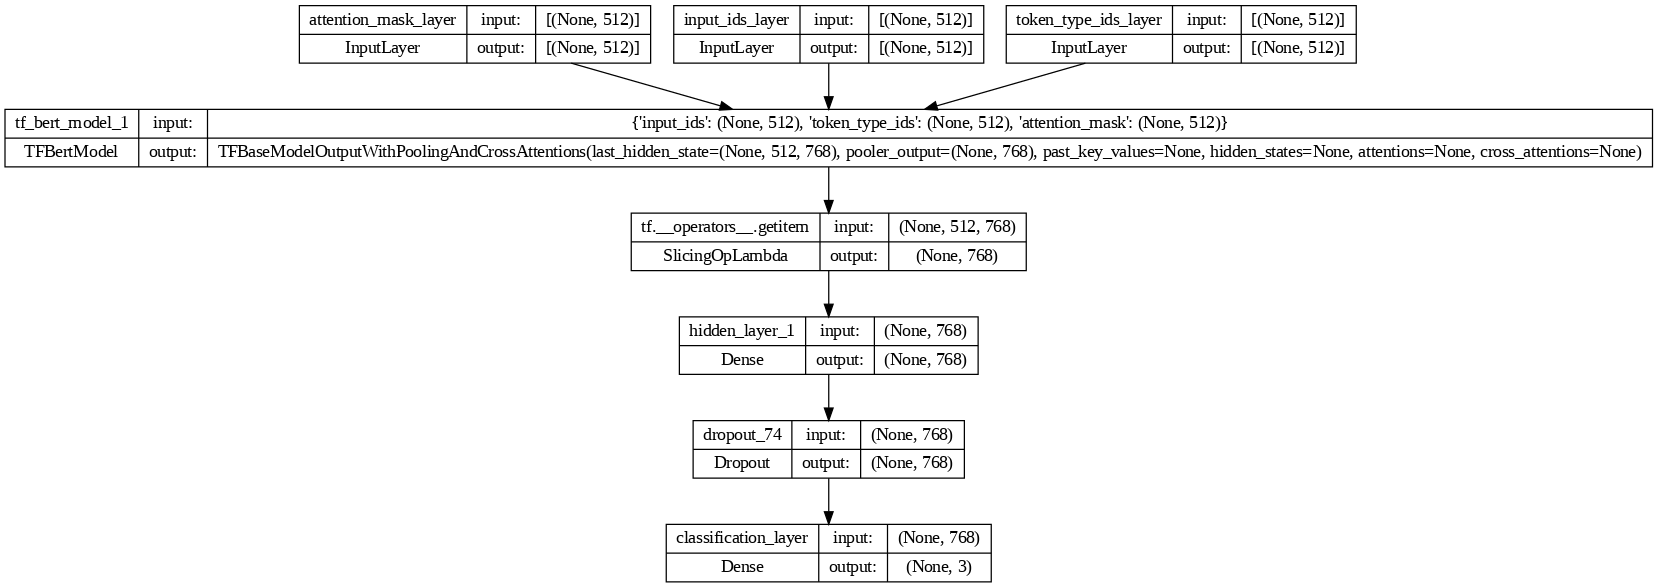

In [34]:
keras.utils.plot_model(bert_classification_model, show_shapes=True, dpi=90)

In [35]:
from tensorflow.keras.callbacks import EarlyStopping
# Early stopping callback to avoid overfitting issue
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    mode='max',
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [36]:
bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_validate.input_ids, x_validate.token_type_ids, x_validate.attention_mask], y_validate),
    batch_size=16,
    epochs=4,
    callbacks=[early_stopping]
)

Epoch 1/4


500/500 [==============================] - 273s 477ms/step - loss: 0.6989 - accuracy: 0.6910 - val_loss: 0.4831 - val_accuracy: 0.8031
Epoch 2/4
500/500 [==============================] - 234s 469ms/step - loss: 0.3867 - accuracy: 0.8536 - val_loss: 0.4345 - val_accuracy: 0.8256
Epoch 3/4
500/500 [==============================] - 234s 469ms/step - loss: 0.2435 - accuracy: 0.9119 - val_loss: 0.3684 - val_accuracy: 0.8703
Epoch 4/4
500/500 [==============================] - 234s 468ms/step - loss: 0.1643 - accuracy: 0.9434 - val_loss: 0.4487 - val_accuracy: 0.8559


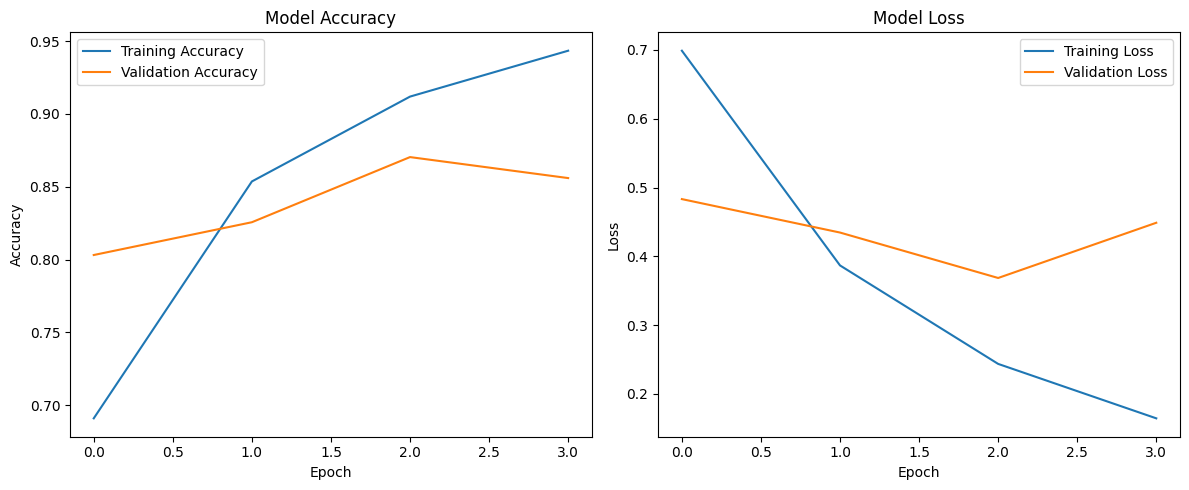

In [37]:
history = bert_classification_model_history.history

# Plotting accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1,2,2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
import tensorflow as tf

x_tests = [x_test1, x_test2, x_test3]
y_tests = [y_test1, y_test2, y_test3]

predictions_all = []
y_true_all = []
accuracies = []
f1_scores = []

for x_test, y_test in zip(x_tests, y_tests):
    predictions_model = bert_classification_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
    predictions_model = tf.argmax(predictions_model, axis=-1)
    predictions_all.extend(predictions_model.numpy())
    y_true_all.extend(y_test)

    acc = accuracy_score(y_test, predictions_model)
    f1 = f1_score(y_test, predictions_model, average='weighted')

    accuracies.append(acc)
    f1_scores.append(f1)

avg_accuracy = np.mean(accuracies)
avg_f1_score = np.mean(f1_scores)

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average F1 Score: {avg_f1_score:.4f}")

# Generate classification report
report = classification_report(y_true_all, predictions_all)
print("\nClassification Report:")
print(report)

63/63 [==============================] - 16s 259ms/step
Average Accuracy: 0.3798
Average F1 Score: 0.4020

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.43      0.49      3404
           1       0.12      0.20      0.15      1072
           2       0.40      0.39      0.39      1524

    accuracy                           0.38      6000
   macro avg       0.36      0.34      0.34      6000
weighted avg       0.44      0.38      0.40      6000



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
f